## Outline {-}

- [Task 1](#task-1): Regression
  - [1.1](#q11) Linear regression
  - [1.2](#q12) Ridge regression
  - [1.3](#q13) Relaxation of LASSO regression
- [Task 2](#task-2): Classification
  - [2.1](#q21) kNN classifier
  - [2.2](#q22) Random forest 
  - [2.3](#q23) Support vector machine (SVM)
  
Importing relevant packages:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use('fivethirtyeight')

# Task 1: Regression {-}

Importing the training data:

In [3]:
chemicals = pd.read_csv('chemistry_samples.csv')

In [4]:
chemicals.head()

,CIC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP,FV1,VFV,FV2,FV3,LC50
0,3.661280,0.658363,1.602232,1.994272,0.836488,3.153623,15.893033,-27.724370,0.059355,0.756698,5.506249
1,3.936362,1.154287,1.146997,0.904295,2.948308,5.141095,13.590177,-31.821521,-13.408855,1.161298,6.636791
2,0.964144,0.415485,1.481028,2.136585,0.043679,-1.156783,15.989419,-3.699312,2.561525,0.500115,1.563388
3,2.074617,1.417296,0.486216,0.000908,-0.066980,2.610960,7.962046,-16.374439,2.448975,1.481888,6.248432
4,1.448569,0.836892,1.951012,0.028318,-0.039121,1.851095,22.285266,-9.526361,2.870400,0.649234,3.676796


Each sample in the data set corresponds to a chemical substance characterized by $10$ features (molecular descriptors). We will consider the toxicity level (column 'LC50') as the target variable to regress, while the other $10$ variables are our predictors. We can see that the $10$ predictors are all continuous variables. We will now carry out an initial exploratory data analysis to gain insight into the data that we are trying to model:

array([[<AxesSubplot:title={'center':'CIC0'}>,
        <AxesSubplot:title={'center':'SM1_Dz(Z)'}>,
        <AxesSubplot:title={'center':'GATS1i'}>],
       [<AxesSubplot:title={'center':'NdsCH'}>,
        <AxesSubplot:title={'center':'NdssC'}>,
        <AxesSubplot:title={'center':'MLOGP'}>],
       [<AxesSubplot:title={'center':'FV1'}>,
        <AxesSubplot:title={'center':'VFV'}>,
        <AxesSubplot:title={'center':'FV2'}>],
       [<AxesSubplot:title={'center':'FV3'}>,
        <AxesSubplot:title={'center':'LC50'}>, <AxesSubplot:>]],
      dtype=object)

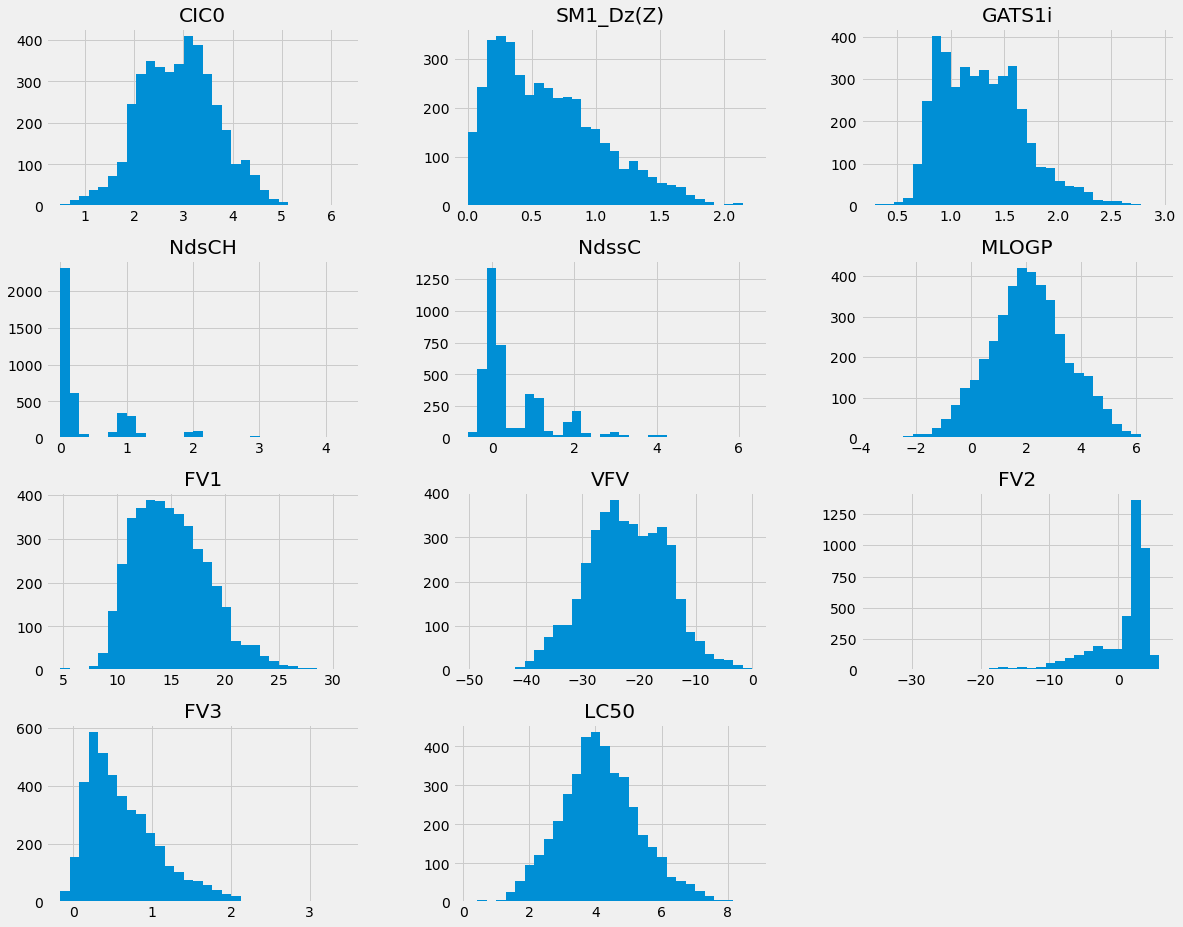

In [5]:
chemicals.hist(bins=30, figsize=(18, 15))

We can immediately notice that some of the predictors have different orders of magnitude (e.g. 'SM1_Dz(Z)' and 'VFV'), suggesting that we should consider normalising our data before modelling. Also, we can see that the variable 'NdsCH' appears to be rather categorical (even though technically it is a continous variable) taking values in the range $\{ 0, 1, 2, 3, 4 \}$. In this regard, we might consider binning these values and using standard encoding techniques when building our final model to see if this improves results. Lastly, we can observe that some variables appear correlated, so we will investigate this next:

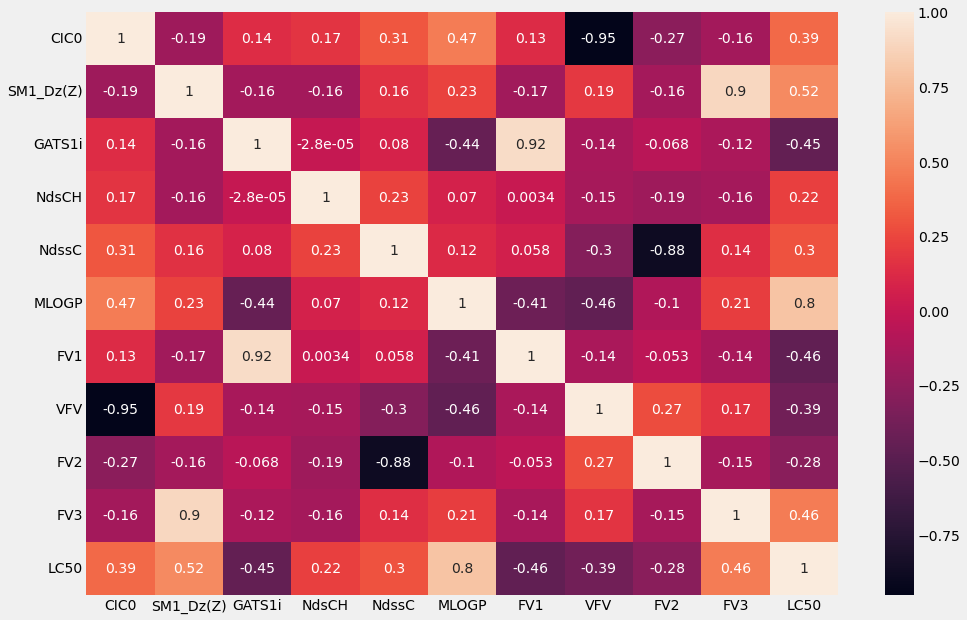

In [6]:
corr_matrix = chemicals.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True)
plt.show()

As remarked before, we can see that some of the variables are _highly_ correlated (e.g. 'VFV' and 'CIC0') so we might consider dropping some of them from the data set (for instance those with a correlation higher than $0.8$) when building our final model to see if this improves results.

## 1.1  {-}

To ensure that the modelling results for the test data are unbiased, we need to make sure that the columns of the test set are normalised using the mean and the standard deviation of the columns in the train set:

In [7]:
def standardise(X, X_test=None):

    # compute mean and standard deviation for each column in the train set
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    
    # if we need to normalise the train set
    if X_test is None:
        X_std = (X - mu) / sigma
        return X_std
    # if we need to normalise the test set
    else:
        X_test_std = (X_test - mu) / sigma
        return X_test_std

In [8]:
def augument(X):

    # augument X with a column of ones (the intercept term)
    N = np.shape(X)[0]
    X_aug = np.hstack([np.ones((N, 1)), X])

    return X_aug

As seen in the lecture notes, for the ordinary least squares problem
$$y = X \beta \text{ and } L(\beta) = \frac{1}{N}\|y - X \beta \|^2$$

the solution $\hat{\beta}$ can be obtained by solving the normal equations (obtained by setting $\nabla_\beta L = 0$) and is given by
$$\hat{\beta} = (X^T X)^{-1}X^T y \text{.}$$

In [9]:
def get_beta(X, y):

    # augument matrix X
    X_aug = augument(X)

    # solve the normal equations
    beta = np.linalg.solve(X_aug.T @ X_aug, X_aug.T @ y)

    return beta.reshape(-1, 1)

In [10]:
def get_prediction(X_test, beta):

    # augument matrix X
    X_test_aug = augument(X_test)
    
    # get y_hat = X * beta
    prediction = X_test_aug @ beta

    return prediction

### Error metrics {-}

We will now define two important error metrics that we will use to evaluate model performance (and also for cross-validation later on):

In [11]:
def R2_score(y_test, y_pred):
    
    # compute residual sum of squares
    SS_res = np.sum((y_test - y_pred) ** 2)
    
    # compute total sum of squares
    y_avg = np.mean(y_test)
    SS_tot = np.sum((y_test - y_avg) ** 2)
    
    # compute 1 - SS_res/SS_tot
    R2 = 1 - (SS_res / SS_tot)

    return R2

In [12]:
def MSE(y_test, y_pred):

    error = y_test - y_pred
    return np.linalg.norm(error) / len(error)

Training a linear regression model on the train data:

In [13]:
# prepare the train data for modelling
target = 'LC50'

# remove target variable and normalise X
X = chemicals.loc[:, chemicals.columns != target].to_numpy()
X_train = standardise(X)

# store target variable labels
y_train = chemicals[target].to_numpy().reshape(-1, 1)

In [14]:
# train the model and store coefficients
beta_LR = get_beta(X_train, y_train)

In [15]:
# get predictions and compute the R2 score for the train data
y_pred = get_prediction(X_train, beta_LR)
R2_train = R2_score(y_train, y_pred)
print('R2 score for the train data: {}'.format(R2_train))

R2 score for the train data: 0.8718259975718016


Testing the model on the test data:

In [16]:
# importing the test data
chemicals_test = pd.read_csv('chemistry_test.csv')

In [17]:
# prepare the test data for modelling
# remove target variable and normalise X
X_test = chemicals_test.loc[:, chemicals_test.columns != target].to_numpy()
X_test = standardise(X, X_test)

# store target variable labels
y_test = chemicals_test[target].to_numpy().reshape(-1, 1)

In [18]:
# get predictions and compute the R2 score for the test data
y_test_pred = get_prediction(X_test, beta_LR)
R2_test = R2_score(y_test, y_test_pred)
print('R2 score for the test data: {}'.format(R2_test))

R2 score for the test data: 0.8642933369927281


As expected, we see that the $R^2$ score for the test data is lower than the $R^2$ score for the train data. However, the two values are comparable ($R_{test}^2$ is not much lower than $R_{train}^2$) and they can be considered high, suggesting that our model is performing well both in and out of sample (it generalizes well; around $87 \%$ of the regressor's variance can be explained by our model).

## 1.2 {-}

As seen in the lecture notes, for the ridge regression problem
$$y = X \beta \text{ and } L(\beta; \lambda) = \frac{1}{N} \|y - X \beta \|^2 + \lambda \| \beta \|^2$$

the solution $\hat{\beta}$ can again be obtained by solving the modified normal equations (obtained by setting $\nabla_\beta L = 0$) and is given by
$$\hat{\beta} = (X^T X + \lambda I)^{-1} X^T y \text{.}$$

In [19]:
def ridge_get_beta(X, y, penalty):
    
    # augument matrix X
    X_aug = augument(X)
    
    # solve the modified normal equations
    I = np.eye(X_aug.shape[1])
    beta_ridge = np.linalg.solve(X_aug.T @ X_aug + penalty * I, X_aug.T @ y)

    return beta_ridge

### Cross-validation {-}

We will now introduce a cross-validation procedure to identify the optimal hyperparameter $\lambda$ for the ridge regression.

In [20]:
def cross_validation_split(N, num_folds=5):
    np.random.seed(42)

    # compute fold size
    fold_size = N // num_folds
    
    # permute the rows of the data
    index_perm = np.random.permutation(np.arange(N))

    folds = []

    for k in range(num_folds):
        # store the permuted indices corresponding to each fold
        folds.append(index_perm[k*fold_size:(k+1)*fold_size])

    return folds

In [21]:
def cross_validation_evaluate_reg(data, penalty, method, num_folds=5):
    
    # compute the indices for the k folds
    folds = cross_validation_split(data.shape[0], num_folds=num_folds)
    
    train_scores = []
    validation_scores = []
    
    for i in range(len(folds)):
        
        # use one of the folds for validation
        val_ind = folds[i]
        # use k - 1 folds for training the model
        train_ind = list(set(range(data.shape[0])) - set(val_ind))
        
        # get the train set
        X_train = data[train_ind, :-1]
        y_train = data[train_ind, -1].reshape(-1, 1)
        
        # get the validation set
        X_val = data[val_ind, :-1]
        y_val = data[val_ind, -1].reshape(-1, 1)
        
        # train the (desired) model and store the coefficients
        if method == 'ridge':
            beta = ridge_get_beta(X_train, y_train, penalty=penalty)
        elif method == 'LASSO':
            beta = LASSO_get_beta(X_train, y_train, penalty=penalty)
        else:
            raise ValueError('method unkown')
        
        # compute the MSE for the train set and validation set
        train_score = MSE(y_train, get_prediction(X_train, beta))
        val_score = MSE(y_val, get_prediction(X_val, beta))
        
        # store the MSE for the train set and validation set
        train_scores.append(train_score)
        validation_scores.append(val_score)
    
    return train_scores, validation_scores

Computing optimal hyperparameter $\lambda$ for the ridge regression:

In [22]:
# stack the train data (X and y) in one array
data = np.hstack([X_train, y_train])

# values of lambda to try for cross-validation
penalty_list = [10 ** i for i in range(-6, 7)]

mean_scores_ridge = {}

for penalty in penalty_list:
    # obtain the k validation scores for current lambda
    scores = cross_validation_evaluate_reg(data, penalty=penalty, method='ridge')[1]
    # store their average
    mean_scores_ridge[penalty] = np.mean(scores)

In [23]:
mean_scores_ridge

{1e-06: 0.015109189776533383,
 1e-05: 0.015109189775487614,
 0.0001: 0.015109189765030557,
 0.001: 0.015109189660526864,
 0.01: 0.01510918862217778,
 0.1: 0.01510917890736932,
 1: 0.015109148528244626,
 10: 0.015115424765858873,
 100: 0.015752317212750843,
 1000: 0.03748926751818274,
 10000: 0.11209864018451357,
 100000: 0.14527171330778788,
 1000000: 0.14986668085009733}

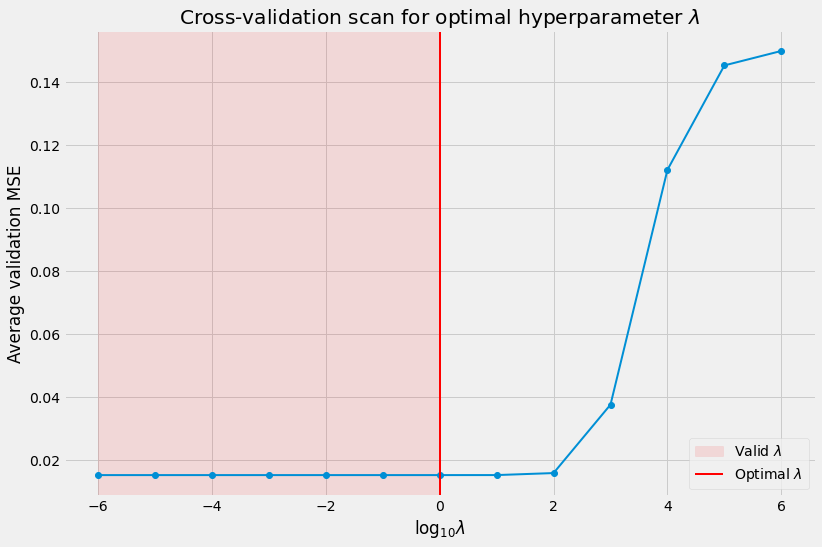

In [24]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(-6, 7), mean_scores_ridge.values(), '-o', linewidth=2)
plt.xlabel(r'$\log_{10} \lambda$')
plt.ylabel('Average validation MSE')
plt.title('Cross-validation scan for optimal hyperparameter 'r'$\lambda$')
plt.axvspan(-6, 0, color='red', alpha=0.1, label='Valid 'r'$\lambda$')
plt.axvline(0, color='red', linewidth=2, label='Optimal 'r'$\lambda$')
plt.legend()

In [25]:
# extract the value of lambda that produces the smallest average validation MSE across the k folds
penalty = min(mean_scores_ridge, key=mean_scores_ridge.get)

print('Optimal lambda = {}; Average MSE for the validation set = {}'.format(penalty, mean_scores_ridge[penalty]))

# train the model using this optimal value of lambda and store coefficients
beta_ridge = ridge_get_beta(X_train, y_train, penalty=penalty)

Optimal lambda = 1; Average MSE for the validation set = 0.015109148528244626


_Note:_  We can see that even though the optimal value of $\lambda$ appears to be $1$, we obtain very similar average validation scores for values of $\lambda$ in range $[10^{-6}, 1]$. Since the case $\lambda = 0$ is equivalent to the ordinary least squares model implemented above, we can conclude that strong regularization in the ridge regression (i.e. $\lambda \gg 1$) does _not_ appear to improve modelling results.

In [26]:
# get prediction and compute R2 score for the train data
y_pred = get_prediction(X_train, beta_ridge)
R2_train = R2_score(y_train, y_pred)
print('R2 score for the train data: {}'.format(R2_train))

R2 score for the train data: 0.871825185348047


In [27]:
# get prediction and compute R2 score for the test data
y_test_pred = get_prediction(X_test, beta_ridge)
R2_test = R2_score(y_test, y_test_pred)
print('R2 score for the test data: {}'.format(R2_test))

R2 score for the test data: 0.8643039338097751


We can see that the $R^2$ scores for both the train data and the test data are very similar to the ones obtained for the regular linear regression. This is not entirely unexpected since the regularization paramter for the ridge regression is rather small (i.e. $\lambda = 1$). All observations for the linear regression are applicable for the ridge regression.

## 1.3 {-}

We will now implement a relaxation of the LASSO regression i.e.
$$y = X \beta \text{ and } L(\beta; \lambda) = \frac{1}{N} \| y - X \beta \|^2 + \lambda \sum_{i=1}^p L_c(\beta_i)$$

where
$$L_c(\beta) = \frac{1}{2} \beta^2 \text{ for } |\beta| \leq c \text{ and } c(|\beta| - \frac{c}{2}) \text{ otherwise.}$$

The function $L_c(\beta)$ is differentiable and we have that
$$\frac{\partial{L_c}}{\partial{\beta}} = \beta \text{ for } |\beta| \leq c \text{ and } c \cdot \text{sgn}(\beta) \text{ otherwise.}$$

In [28]:
def huber(beta, c=1e-6):

    p = len(beta)
    
    # obtain L_c for a beta vector
    L_c = np.zeros(p)
    for i in range(p):
        if abs(beta[i][0]) < c:
            L_c[i] = (beta[i][0] ** 2) / 2
        else:
            L_c[i] = c * (abs(beta[i][0]) - c / 2)

    return L_c.reshape(-1, 1)

In [29]:
def grad_huber(beta, c=1e-6):

    p = len(beta)
    
    # obtain dL_c / dbeta for a beta vector
    grad = np.zeros(p)
    for i in range(p):
        if abs(beta[i][0]) < c:
            grad[i] = beta[i][0]
        else:
            grad[i] = c * np.sign(beta[i][0])

    return grad.reshape(-1, 1)

To obtain the coefficient vector $\beta$ in the relaxation of the LASSO regression, we will use gradient descent. For the cost function defined above, we have that
$$\nabla_\beta L = 2 X^T X \beta - 2 X^T y + \lambda \nabla_\beta L_c(\beta)$$

where
$$L_c(\beta) = 
\begin{pmatrix}
L_c(\beta_1) \\
L_c(\beta_2) \\
\vdots \\
L_c(\beta_p)
\end{pmatrix}
\text{.} $$

i.e. the function $L_c$ is applied component-wise to $\beta$. Hence, we have that
$$\nabla_\beta L_c(\beta) = 
\begin{pmatrix}
\frac{\partial{L_c}}{\partial{\beta}}(\beta_1) \\
\frac{\partial{L_c}}{\partial{\beta}}(\beta_2) \\
\vdots \\
\frac{\partial{L_c}}{\partial{\beta}}(\beta_p)
\end{pmatrix}
$$

since there are no higher order (coupled) terms in the sum $\displaystyle \sum_{i=1}^p L_c(\beta_i)$ in the cost function. Thus, we first initialise the coefficient vector $\beta$ with zeros:

In [30]:
def initialise_beta(X):

    # initialise beta with zeros
    p = X.shape[1]
    beta = np.zeros(p + 1)

    return beta.reshape(-1, 1)

We then implement a forward pass function that evaluates the cost function $L(\beta; \lambda)$ and the gradient (w.r.t. $\beta$) for given a $\beta$ and $\lambda$: 

In [31]:
def propagate(X, y, beta, penalty):
    
    # compute cost L
    cost = np.linalg.norm(X @ beta - y) + penalty * np.sum(huber(beta, c=0.001))
    
    # compute gradient dL / dbeta
    dbeta = 2 * X.T @ X @ beta - 2 * X.T @ y + penalty * grad_huber(beta, c=0.001)
    dbeta = dbeta.reshape(-1, 1)
    
    return dbeta, cost

Lastly, with the gradients and costs, we can conduct the actual optimisation and update $\beta$ with a learning rate $\alpha$ (that we will set to $0.0005$ to ensure convergence) i.e.
$$\beta = \beta - \alpha \nabla_\beta L \text{.}$$

In [32]:
def optimise(X, y, beta, penalty, num_iterations=2500, learning_rate=0.00005, print_cost=False):

    costs = []

    for i in range(num_iterations):

        # compute gradient and cost at current iteration
        dbeta, cost = propagate(X, y, beta, penalty)

        # update beta
        beta -= learning_rate * dbeta

        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print('Cost at iteration {}: {}'.format(i, cost))
       
    return beta, costs

In [33]:
def LASSO_get_beta(X, y, penalty, num_iterations=2500, learning_rate=0.00005, print_cost=False):

    # initialise beta with zeros
    beta_LASSO = initialise_beta(X)

    # augument matrix X
    X_aug = augument(X)

    # use gradient descent to obtain beta
    beta_LASSO, costs = optimise(X_aug, y, beta_LASSO, penalty, num_iterations, learning_rate, print_cost)

    return beta_LASSO

We will now employ the cross-validation method implemented above to compute the optimal hyperparameter $\lambda$ for the relaxation of the LASSO regression:

In [34]:
# lambda values to try for cross-validation
penalty_list = [10 ** i for i in range(-6, 7)]

mean_scores_LASSO = {}

for penalty in penalty_list:
    # obtain the k validation scores for current lambda
    scores = cross_validation_evaluate_reg(data, penalty=penalty, method='LASSO')[1]
        # store their average
    mean_scores_LASSO[penalty] = np.mean(scores)

In [35]:
mean_scores_LASSO

{1e-06: 0.015109189776648583,
 1e-05: 0.015109189776639585,
 0.0001: 0.015109189776549587,
 0.001: 0.015109189775649623,
 0.01: 0.015109189766649989,
 0.1: 0.015109189676653792,
 1: 0.015109188776705054,
 10: 0.015109179778543511,
 100: 0.015109089931558637,
 1000: 0.015108232189296167,
 10000: 0.015103509741615381,
 100000: 0.015153967473592572,
 1000000: 0.01976028472172232}

In [36]:
# extract the value of lambda that produces the smallest average validation MSE across the k folds
penalty = min(mean_scores_LASSO, key=mean_scores_LASSO.get)

print('Optimal lambda = {}; Average MSE for the validation set = {}'.format(penalty, mean_scores_LASSO[penalty]))

# train the model using this optimal value of lambda and store coefficients
beta_LASSO = LASSO_get_beta(X_train, y_train, penalty=penalty)

Optimal lambda = 10000; Average MSE for the validation set = 0.015103509741615381


Similar to the results seen for the ridge regression, we obtain very similar average validation scores for a vast array of values of $\lambda$. This time, however, strong regularization (i.e. $\lambda = 10000$) appears to produce comparable results to very weak regularization (i.e. $\lambda = 0.0001$). Hence, in this case, choosing a large $\lambda$ is preferable in order to ensure reduceed over-fitting. _Note:_ In this case, even though the regularization parameter $\lambda$ appears to be large (for instance compared to the regularization parameter obtained for ridge regression), this can be explained by the omission of the $\frac{1}{N}$ term in the cost function $\Big($ i.e. $L(\beta; \lambda) = \|y - X \beta \|^2 + \lambda \displaystyle \sum_{i=1}^p L_c(\beta_i)$; the error term is not normalized $\Big)$. Using this observation, we can conclude that for values of $\lambda$ up to approximatively $10000$, the error term $\| y - X \beta \|^2$ dominates the cost function $L(\beta; \lambda)$. If we would instead normalize the error term in the cost function (multiply by a factor of $\frac{1}{N}$), the cross-validation for the relaxation of the LASSO regression would also suggest that no regularization is needed (i.e. the optimal hyperparameter $\lambda \ll 1$).

In [37]:
# get prediction and compute R2 score for the train data
y_pred = get_prediction(X_train, beta_LASSO)
R2_train = R2_score(y_train, y_pred)
print('R2 score for the train data: {}'.format(R2_train))

R2 score for the train data: 0.8718197393982337


In [38]:
# get prediction and compute R2 score for the test data
y_test_pred = get_prediction(X_test, beta_LASSO)
R2_test = R2_score(y_test, y_test_pred)
print('R2 score for the test data: {}'.format(R2_test))

R2 score for the test data: 0.8643146465208675


### Comparing the models {-}

Text(0.5, 1.0, 'Relaxation of LASSO regression')

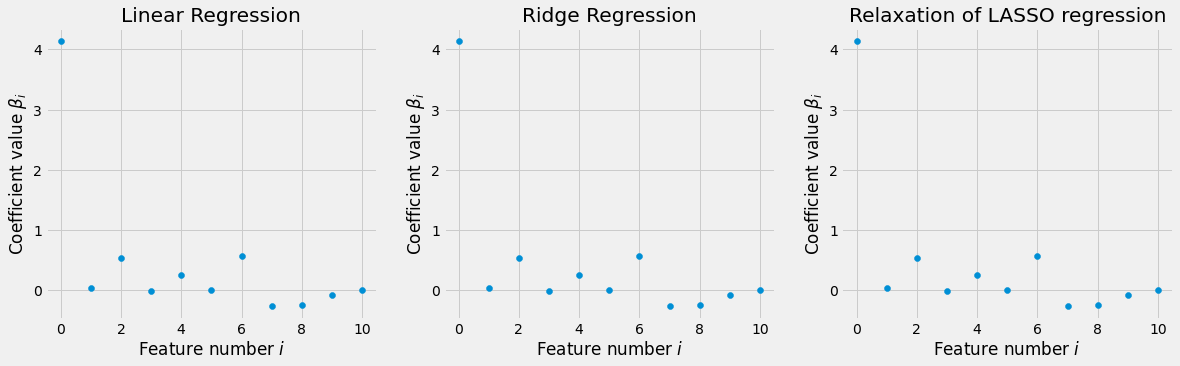

In [39]:
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.scatter(np.arange(0, 11), beta_LR)
plt.xlabel('Feature number 'r'$i$')
plt.ylabel('Coefficient value 'r'$\beta_i$')
plt.title('Linear Regression')
plt.subplot(1, 3, 2)
plt.scatter(np.arange(0, 11), beta_ridge)
plt.xlabel('Feature number 'r'$i$')
plt.ylabel('Coefficient value 'r'$\beta_i$')
plt.title('Ridge Regression')
plt.subplot(1, 3, 3)
plt.scatter(np.arange(0, 11), beta_LASSO)
plt.xlabel('Feature number 'r'$i$')
plt.ylabel('Coefficient value 'r'$\beta_i$')
plt.title('Relaxation of LASSO regression')

As we can see from the figure above (and as we could have inferred from the in and out of sample $R^2$ scores obtained previously), the obtained coefficient vectors $\beta$ are very similar across the 3 models that we tried (linear regression, ridge regression and the relaxation of the LASSO regression). Although we would have probably expected to see improved results when using regularization (ridge and LASSO), these findings are not entirely unjustifiable. One thing that we can immediately note is that we have a 'healthy' number of samples (4111) per number of predictor variables (10) in our data set, so regularization was never guaranteed to improve results since the regular linear regression is a simple enough model. If our data set contained (considerably) more fearures, then regularization (alongside some feature engineering) would've been vital to prevent over-fitting. One final thing to note is that even though the data (both the train and the test set) was normalized, an intercept term was added in all 3 of the models (not doing so would lead to _negative_ $R^2$ scores, suggesting that these models perform very poorly).

Since the 3 models produce very similar results, we could use any of them to predict new samples. Theoretically, the regular linear regression should be the simplest (and the most interpretable), while the ridge or LASSO regression should be more robust and less prone to over-fitting. As mentioned in the EDA, some potential improvements to our model are removing some of the highly correlated features (although this is not really neccesary since we already have a small number of features) and trying to bin the 'NdsCH' feature (most likely with bins $\{0, 1, 2, 3, 4 \}$).

# Task 2: Classification {-}

Importing the training data:

In [40]:
tumours = pd.read_csv('tumour_samples.csv')
tumours = tumours.drop(['Unnamed: 0'], axis=1)

In [41]:
tumours.head()

,n1_radius,n1_texture,n1_perimeter,n1_area,n1_smoothness,n1_compactness,n1_concavity,n1_concave_points,n1_symmetry,n1_fractal_dimension,...,n3_texture,n3_perimeter,n3_area,n3_smoothness,n3_compactness,n3_concavity,n3_concave_points,n3_symmetry,n3_fractal_dimension,DIAGNOSIS
0,10.855170,15.248290,69.167041,359.534878,0.105488,0.080200,0.066410,0.034194,0.182796,0.066968,...,18.984557,81.443134,466.879302,0.149080,0.200185,0.205695,0.111592,0.335999,0.093477,B
1,10.068958,15.532758,66.130635,330.040665,0.099813,0.109540,0.057583,0.023322,0.195650,0.069572,...,22.840293,82.133171,473.367822,0.125478,0.330466,0.283304,0.088021,0.312882,0.096158,B
2,12.271409,18.100314,78.195610,421.537832,0.105147,0.095315,0.043317,0.031539,0.188801,0.063341,...,26.365608,84.598334,620.586067,0.146766,0.118707,0.147900,0.050402,0.291805,0.069556,B
3,10.531733,18.452486,67.227069,340.063033,0.086041,0.049961,0.049709,0.011046,0.203093,0.064948,...,24.385385,73.296855,429.675600,0.100060,0.143683,0.177225,0.028111,0.287749,0.073174,B
4,12.367686,14.399191,80.643814,460.849710,0.106410,0.101420,0.020806,0.021990,0.195326,0.064605,...,19.614305,89.910502,472.323112,0.138135,0.276127,0.151098,0.074396,0.345258,0.095830,B


Our second task is concerned with correctly classifying breast tumours as benign or malignant based on $30$ features. The column 'DIAGNOSIS' corresponds to the tumour classification where 'B' stands for 'benign' and 'M' stands for 'malignant'. We will now carry out an initial exploratory data analysis to gain insight into the data that we are trying to model:

array([[<AxesSubplot:title={'center':'n1_radius'}>,
        <AxesSubplot:title={'center':'n1_texture'}>,
        <AxesSubplot:title={'center':'n1_perimeter'}>,
        <AxesSubplot:title={'center':'n1_area'}>,
        <AxesSubplot:title={'center':'n1_smoothness'}>],
       [<AxesSubplot:title={'center':'n1_compactness'}>,
        <AxesSubplot:title={'center':'n1_concavity'}>,
        <AxesSubplot:title={'center':'n1_concave_points'}>,
        <AxesSubplot:title={'center':'n1_symmetry'}>,
        <AxesSubplot:title={'center':'n1_fractal_dimension'}>],
       [<AxesSubplot:title={'center':'n2_radius'}>,
        <AxesSubplot:title={'center':'n2_texture'}>,
        <AxesSubplot:title={'center':'n2_perimeter'}>,
        <AxesSubplot:title={'center':'n2_area'}>,
        <AxesSubplot:title={'center':'n2_smoothness'}>],
       [<AxesSubplot:title={'center':'n2_compactness'}>,
        <AxesSubplot:title={'center':'n2_concavity'}>,
        <AxesSubplot:title={'center':'n2_concave_points'}>,
    

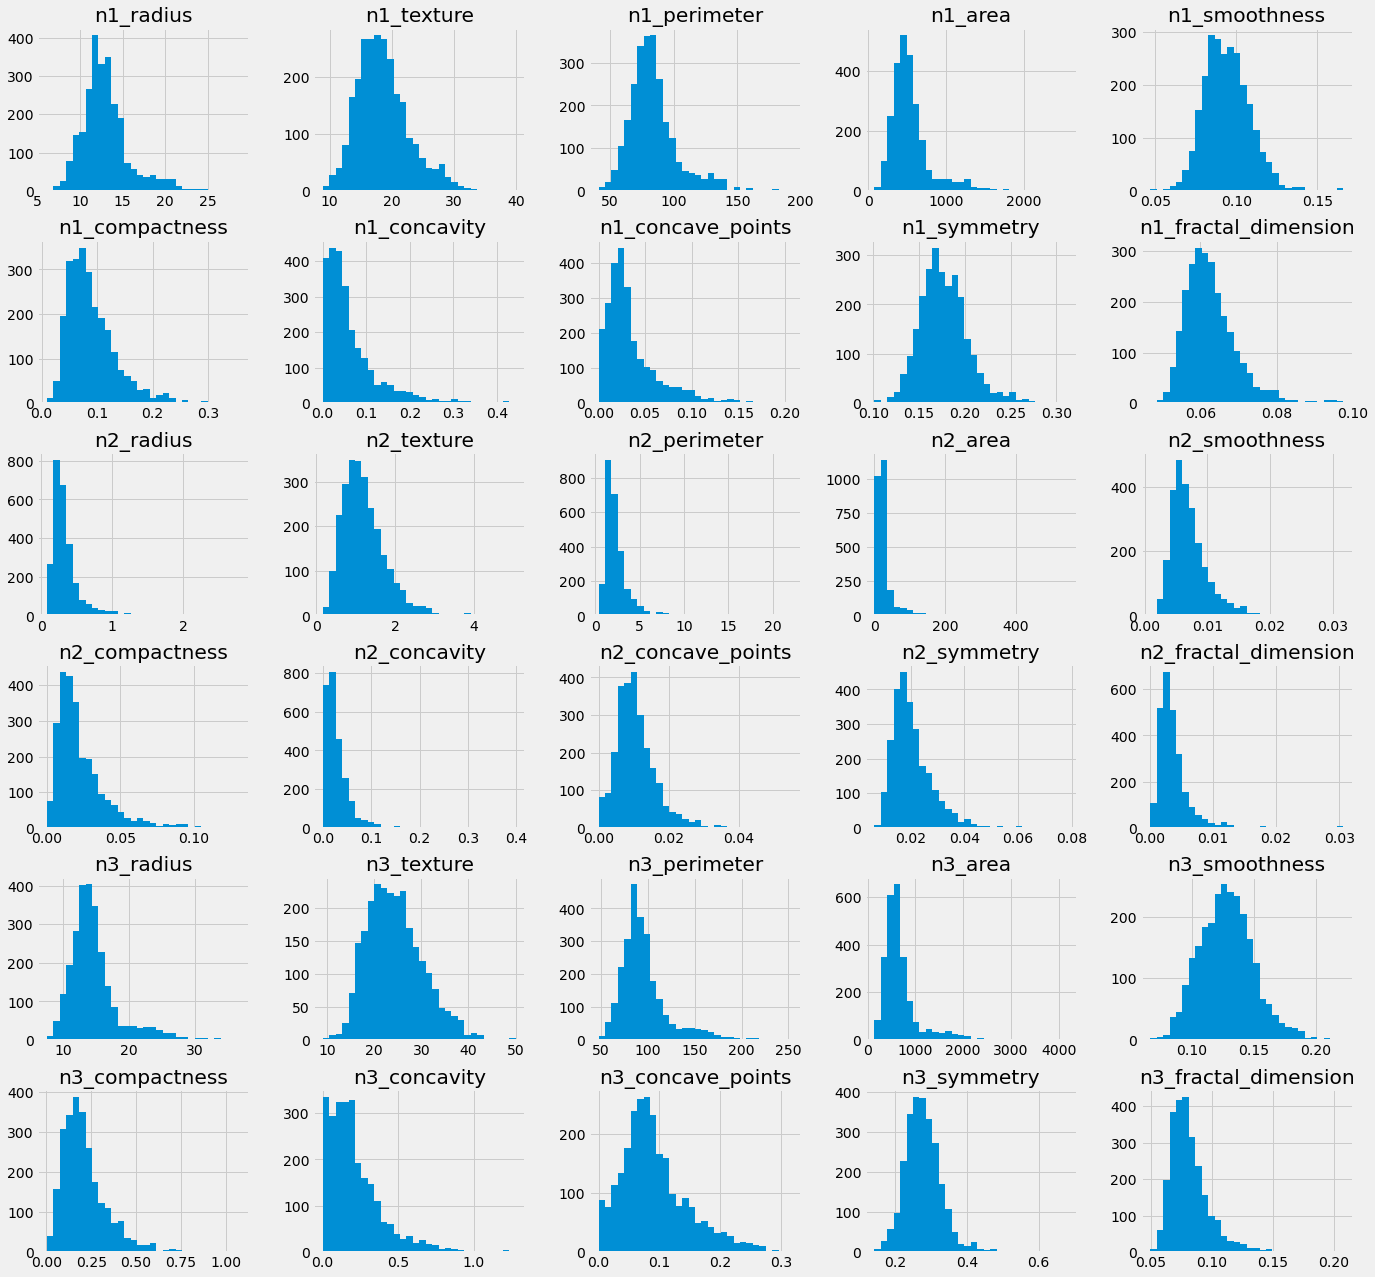

In [42]:
tumours.hist(bins=30, figsize=(21, 21))

<AxesSubplot:>

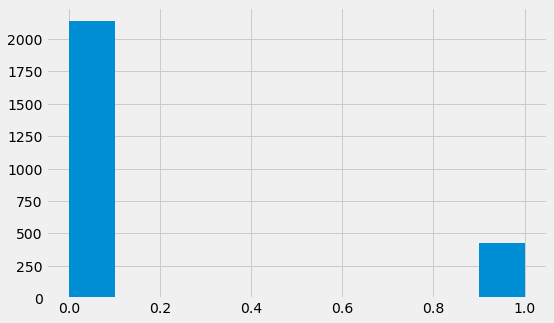

In [43]:
tumours = tumours.replace({'B': 0, 'M': 1})

plt.figure(figsize=(8, 5))
tumours['DIAGNOSIS'].hist()

One thing that we can immediately notice is that we are working with an _imbalanced_ data set i.e. the number of positive samples (corresponding to malignant tumours in our case) is much lower than the number or negative samples (corresponding to benign tumours in our case). We should therefore proceed with care in our modelling, and keep in mind that correctly classifying malignant tumours is much more important than correctly classifying benign tumours (we are much more interested in obtaining as many true positives as possible). In this regard, we need to carefully choose the metric by which we evaluate our models (e.g. using accuracy as a metric migh not be suitable as we are likely to encounter high values - it will be diluted by the big number of negatives).

## 2.1 {-}

To perform a k-NN classification, we first need to define a distance function. We will use the Euclidian distance:

In [44]:
def euclidian_distance(p, q):
    return np.sqrt(np.sum((p - q) ** 2, axis=1))

For a (new) point $x$, we first need to compute its distance to every data point in the train set and then identify (and store) its $k$ nearest neighbours:

In [45]:
def k_neighbours(X_train, X_test, k=5, return_distance=False):
    
    dist = []
    neigh_ind = []
  
    # compute distance to every point in the train set
    point_dist = [euclidian_distance(x_test, X_train) for x_test in X_test]

    # iterate through the distances
    for row in point_dist:
        
        # sort the points in the train set by their distance to the new point
        enum_neigh = enumerate(row)
        # identify the first k points
        sorted_neigh = sorted(enum_neigh, key=lambda x: x[1])[:k]

        # store their indices
        ind_list = [tup[0] for tup in sorted_neigh]
        # store their distances
        dist_list = [tup[1] for tup in sorted_neigh]

        # append each to their respective list
        dist.append(dist_list)
        neigh_ind.append(ind_list)

    if return_distance:
        return np.array(dist), np.array(neigh_ind)
  
    else:
        return np.array(neigh_ind)

We can then predict the label for our new data point $x$, using the "majority vote" rule for its $k$ nearest neighbours:

In [46]:
def predict_knn(X_train, y_train, X_test, k=5):
    
    # get the k nearest neighbours of the new point
    neighbours = k_neighbours(X_train, X_test, k=k)
    
    # apply "majority vote" rule for these k points
    y_pred = np.array([np.argmax(np.bincount(y_train[neighbour])) for neighbour in neighbours])

    return y_pred

### Error metrics {-}

We will now define some important metrics (some of which are based on the confusion matrix) that we will use to evaluate model performance (and also for cross-validation and creating a ROC curve later on):

In [47]:
def accuracy(y_test, y_pred):
    return np.mean(y_pred == y_test)

In [48]:
def confusion_matrix(y_test, y_pred):
    
    # initialize confusion matrix elements with zeros
    TP, TN, FP, FN = 0, 0, 0, 0
    
    # iterate through the (predicted and actual) labels
    for i in range(len(y_test)):
        if y_test[i] != 1:
            if y_pred[i] != 1:
                TN += 1
            else:
                FP += 1
        else:
            if y_pred[i] == 1:
                TP += 1
            else:
                FN += 1

    # build confusion matrix
    confusion_mat = np.array([[TP, FP], [FN, TN]])

    return confusion_mat

In [49]:
def true_positive_rate(y_test, y_pred):
    confusion_mat = confusion_matrix(y_test, y_pred)
    TP = confusion_mat[0, 0]
    FN = confusion_mat[1, 0]
    TPR = TP / (TP + FN)
    return TPR

In [50]:
def false_positive_rate(y_test, y_pred):
    confusion_mat = confusion_matrix(y_test, y_pred)
    FP = confusion_mat[0, 1]
    TN = confusion_mat[1, 1]
    FPR = FP / (FP + TN)
    return FPR

In [51]:
def f1_score(y_test, y_pred):
    confusion_mat = confusion_matrix(y_test, y_pred)
    TP = confusion_mat[0, 0]
    FP = confusion_mat[0, 1]
    FN = confusion_mat[1, 0]
    F1 = (2 * TP) / (2 * TP + FP + FN)
    return F1

### Cross-validation {-}

We will now introduce a cross-validation procedure to identify the optimal hyperparameter $k$ for the k-NN classifier.

In [52]:
def cross_validation_evaluate_knn(data, k, num_folds=5):
    
    # compute indices for the k folds
    folds = cross_validation_split(data.shape[0], num_folds=num_folds)
    
    train_scores = []
    validation_scores = []
    
    for i in range(len(folds)):
        
        # use on the folds for validation
        val_ind = folds[i]
        # use k - 1 folds for training
        train_ind = list(set(range(data.shape[0])) - set(val_ind))
        
        # get the train set
        X_train = data[train_ind, :-1]
        y_train = data[train_ind, -1].astype(int)
        
        # get the validation set
        X_val = data[val_ind, :-1]
        y_val = data[val_ind, -1].astype(int)
        
        # train the k-NN model and store predictions
        y_pred = predict_knn(X_train, y_train, X_train, k=k)
        y_val_pred = predict_knn(X_train, y_train, X_val, k=k)
        
        # compute accuracy for the train set and validation set
        train_score = accuracy(y_train, y_pred)
        val_score = accuracy(y_val, y_val_pred)
        
        # store the accuracy for the train set and validation set
        train_scores.append(train_score)
        validation_scores.append(val_score)
    
    return train_scores, validation_scores

Finding optimal parameter $k$ for the k-NN model:

In [53]:
target = 'DIAGNOSIS'

X = tumours.loc[:, tumours.columns != target].to_numpy()
X_train = standardise(X)
y_train = tumours[target].to_numpy()

data = np.hstack([X_train, y_train.reshape(-1, 1)])

In [54]:
mean_scores_knn = {}

for k in range(1, 21):
    scores = cross_validation_evaluate_knn(data, k=k)[1]
    mean_scores_knn[k] = np.mean(scores)

In [55]:
mean_scores_knn

{1: 0.9953216374269005,
 2: 0.9808966861598443,
 3: 0.9832358674463937,
 4: 0.9793372319688111,
 5: 0.9816764132553606,
 6: 0.9773879142300196,
 7: 0.9805068226120858,
 8: 0.9785575048732943,
 9: 0.9805068226120858,
 10: 0.9781676413255361,
 11: 0.9793372319688108,
 12: 0.9785575048732944,
 13: 0.9805068226120858,
 14: 0.9785575048732943,
 15: 0.9793372319688108,
 16: 0.9758284600389864,
 17: 0.9777777777777779,
 18: 0.9754385964912281,
 19: 0.9754385964912281,
 20: 0.9734892787524366}

Text(0.5, 1.0, 'Cross-validation scan for optimal hyperparameter $k$')

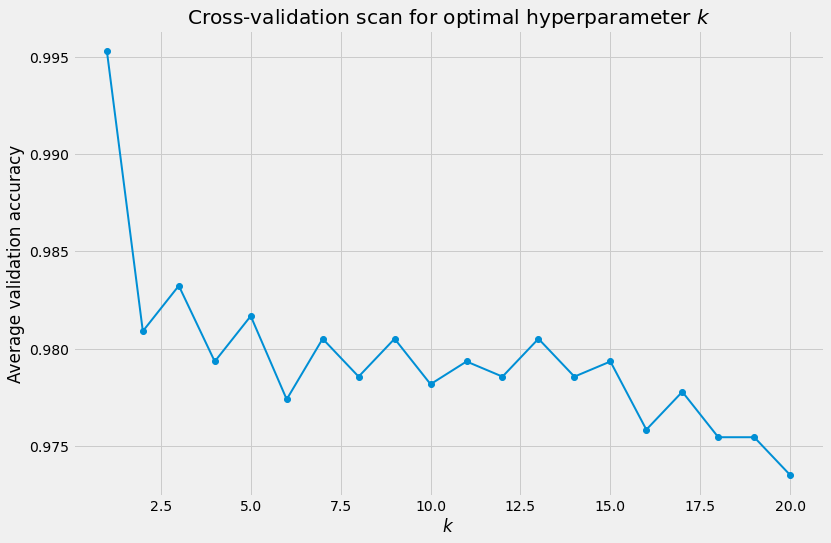

In [56]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, 21), mean_scores_knn.values(), '-o', linewidth=2)
plt.xlabel(r'$k$')
plt.ylabel('Average validation accuracy')
plt.title('Cross-validation scan for optimal hyperparameter 'r'$k$')

In [57]:
k = max(mean_scores_knn, key=mean_scores_knn.get)

print('Optimal k = {}; Average accuracy for the validation set = {}'.format(k, mean_scores_knn[k]))

Optimal k = 1; Average accuracy for the validation set = 0.9953216374269005


Training a k-NN model on the train data:

In [58]:
y_pred = predict_knn(X_train, y_train, X_train, k=k)
acc_train = accuracy(y_train, y_pred)
print('Accuracy for the train data: {}'.format(acc_train))

Accuracy for the train data: 1.0


Testing the model on the test data:

In [59]:
tumours_test = pd.read_csv('tumour_test.csv')
tumours_test = tumours_test.drop(['Unnamed: 0'], axis=1)
tumours_test = tumours_test.replace({'B': 0, 'M': 1})

In [60]:
X_test = tumours_test.loc[:, tumours_test.columns != target].to_numpy()
X_test = standardise(X, X_test)
y_test = tumours_test[target].to_numpy()

In [61]:
y_test_pred = predict_knn(X_train, y_train, X_test, k=k)
acc_test = accuracy(y_test, y_test_pred)
print('Accuracy for test data: {}'.format(acc_test))

Accuracy for test data: 1.0


We can see that the cross-validation procedure suggests that $k=1$ is the best value for our hyperparameter. Unsurprisingly, the train set accuracy is then observed to be $100\%$, which is to be expected since the closest neighbour of any point in the train set is the point itself! This is because all the points in the train set were already seen by the model and used for the training (so the score is not at all informative!). On the other hand, what is somewhat surprising is that the test set accuracy is also $100\%$. This is not entirely unexpected, since the cross-validation suggests that a model with $k=1$ should generalize well (it recorded a $99.53\%$ out of sample accuracy), suggesting that the positives (points with $y^{(i)} = 1$) may be clustered together very well. Still, in practice, a choice of $k=1$ is very prone to over-fitting, so care should be taken when applying the model at scale (an idea would be to try to look at other error metrics for a large-scale generalization). Lastly, looking at the figure above, we can see that a choice of $k=3$ might also be a good hyperparameter choice (notice that, in general, odd $k$'s tend to produce better results; this may be due to the fact that the "majority vote" rule applies better to an odd number of points).

## 2.2 {-}

We will now implement a random forest classifier, employing the cross-entropy as the information criterion for the splits in the decision trees. For a region $R_\alpha$ with label probability distribution $\pi(R_\alpha)$, the cross-entropy is defined as
$$\text{CE} \Big( (\pi(R_\alpha) \Big) = - \sum_{q=1}^Q \pi_q(R_\alpha) \log \big( \pi_q(R_\alpha) \big) \text{.}$$

In [62]:
def cross_entropy(y):
    
    # initialize pi_q with 0 for each label in the region
    yi_freq = {yi: 0 for yi in set(y)}
    total = len(y)

    # count how many times each label appears in the region
    for yi in y:
        yi_freq[yi] += 1
    
    # initialize cross-entropy with 0
    CE = 0
    
    # iterate through the labels in the region
    for yi, freq in yi_freq.items():
        # normalize (to get probability)
        prob = freq / total
        # update cross-entropy
        CE -= prob * np.log(prob)
        
    return CE

In our data set, all the predictors are continuous variables, so for a feature $j$ and a threshold $s$, the samples with feature value less than $s$ are assigned to the left and vice versa:

In [63]:
def split_samples(X, y, column, value):
    
    # define mask
    left_mask = (X[:, column] < value)
    
    # assign samples accordingly
    X_left, X_right = X[left_mask, :], X[~left_mask, :]
    y_left, y_right = y[left_mask], y[~left_mask]
    
    return (X_left, X_right), (y_left, y_right)

Given a column $j$, we need to compute the optimal threshold $s$ to split our data (i.e. the values $s$ produces the _maximum_ information gain or the _minimum_ cross-entropy). Here, by cross-entropy we mean the sum of the resulting cross-entropies for the two resulting regions, weighted accordingly (by the fraction of points from the parent node that end up in each region):
$$\text{CE}(y, j, s) = p_{\text{left}} \cdot \text{CE}(y_{\text{left}}) + p_{\text{right}} \cdot \text{CE}(y_{\text{right}}) \text{.}$$

In [64]:
def CE_split_value(X, y, column):
    
    # extract the unique values and check that there are at least two of them
    unique_vals = np.unique(X[:, column])
    assert len(unique_vals) > 1, 'There must be more than one distinct feature value.'
    
    # initialize cross-entropy and threshold
    CE_val, threshold = np.inf, None
    
    # iterate through the unique values
    for value in unique_vals:

        # split samples according to current value
        (X_l, X_r), (y_l, y_r) = split_samples(X, y, column=column, value=value)
        
        # compute the number of points that end up in each region
        p_left, p_right = len(y_l), len(y_r)
        
        # compute associated cross-entropy
        new_cost = p_left * cross_entropy(y_l) + p_right * cross_entropy(y_r)
        
        # update minimal cross-entropy and threshold (if applicable)
        if new_cost < CE_val:
            CE_val = new_cost
            threshold = value
            
    return CE_val, threshold

We now need to iterate though all the features in the train set to see which combination of column $j$ and threshold $s$ produces the minimal cross-entropy. Since our goal is to train a random forest, we will need to employ feature bagging (i.e. only looking at a _random_ subset of features when choosing the combination of column $j$ and threshold $s$):

In [65]:
def CE_split_rf(n_features, X, y):

    p = X.shape[1]
    columns = np.random.choice(np.arange(p), n_features, replace=False)
    
    min_CE, split_column, split_value = np.inf, 0, 0
    
    for column in columns:
        if len(np.unique(X[:, column])) < 2:
            continue
        
        CE, val = CE_split_value(X, y, column=column)
        if CE < min_CE:
            min_CE = CE
            split_column = column
            split_value = val
    
    return split_column, split_value

Lastly, we need to implement a "majority vote" rule in order to assign a label $q$ to a region $R_\alpha$:

In [66]:
def majority_vote(y):
    
    # initialize counter of each label in the region with 0
    yi_freq = {yi: 0 for yi in y}
    
    # count how many times each label appears in the region
    for yi in y:
        yi_freq[yi] += 1
    
    # choose the one that has the highest frequency
    return max(yi_freq, key=yi_freq.get)

We can now use the functions implemented above to create a decision tree:

In [67]:
def build_tree_rf(n_features, X, y, depth, max_depth, min_samples_leaf=10):
        
    # if (any) termination criteria is met
    if len(np.unique(y)) == 1 or depth >= max_depth or len(X) <= min_samples_leaf:
        # assign majority label to (leaf) region
        return {'majority_label': majority_vote(y)}
    
    # recursive step
    else:
        
        # compute optimal split
        split_index, split_val = CE_split_rf(n_features, X, y)
        # split tree
        (X_l, X_r), (y_l, y_r) = split_samples(X, y, split_index, split_val)
        
        return {
            'feature_index': split_index,
            'value': split_val,
            'majority_label': None,
            'left': build_tree_rf(n_features, X_l, y_l, depth + 1, max_depth, min_samples_leaf),
            'right': build_tree_rf(n_features, X_r, y_r, depth + 1, max_depth, min_samples_leaf)
        }

Finally, we need to create a random forest from multiple decision trees (applying bagging for each tree):

In [68]:
def train_rf(B, n_features, X, y, max_depth, min_samples_leaf=10):
    
    N = X.shape[0]
    training_indices = np.arange(N)
    trees = []
    
    # train random forest
    for _ in range(B):
        
        # apply bagging
        sample = np.random.choice(training_indices, N, replace=True)
        X_sample = X[sample, :]
        y_sample = y[sample]
        
        # train decision tree
        tree = build_tree_rf(n_features, X_sample, y_sample, depth=1, 
                             max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        
        # append decision tree to the random forest
        trees.append(tree)
    
    return trees

We now need to be able to predict a label for a new data point (for each decision tree in the random forest predict a label and then aggregate the results):

In [69]:
def classify(tree, x):

    # if we reached a leaf, assign majority label
    if tree['majority_label'] is not None:
        return tree['majority_label']

    # recursive step
    else:
        # 'descend' the tree until we reach a leaf
        # choose to go left or right accordingly
        if x[tree['feature_index']] < tree['value']:
            return classify(tree['left'], x)
        else:
            return classify(tree['right'], x)

In [70]:
from collections import defaultdict

def predict_rf(rf, X):
    
    # create aggreagation function
    def aggregate(decisions):
        count = defaultdict(int)
        for decision in decisions:
            count[decision] += 1
        return max(count, key=count.get)
    
    # if we only need to classify 1 new point
    if len(X.shape) == 1:
        return aggregate([classify(tree, X) for tree in rf])
    
    # if we need to classify multiple new points
    else:
        return np.array([aggregate([classify(tree, x) for tree in rf]) for x in X])

### Cross-validation {-}

We will now introduce a cross-validation procedure to obtain the optimal number of trees in the random forest and the maximum depth of the decision trees.

In [71]:
def cross_validation_evaluate_rf(data, B, n_features, max_depth, min_samples_leaf=100, num_folds=5):
    
    # compute indices for the k folds
    folds = cross_validation_split(data.shape[0], num_folds=num_folds)
    
    train_scores = []
    validation_scores = []
    
    for i in range(len(folds)):
        
        # use one of the folds for validation
        val_ind = folds[i]
        # use k - 1 folds for training the model
        train_ind = list(set(range(data.shape[0])) - set(val_ind))
        
        # get the train set
        X_train = data[train_ind, :-1]
        y_train = data[train_ind, -1].astype(int)
        
        # get the validation set
        X_val = data[val_ind, :-1]
        y_val = data[val_ind, -1].astype(int)
        
        # train the random forest
        rf = train_rf(B, n_features, X_train, y_train, max_depth, min_samples_leaf)
        
        # predict labels for train set and validation set
        y_pred = predict_rf(rf, X_train)
        y_val_pred = predict_rf(rf, X_val)
        
        # compute accuracy for train set and validation set
        train_score = accuracy(y_train, y_pred)
        val_score = accuracy(y_val, y_val_pred)
        
        # store accuracy for train set and validation set
        train_scores.append(train_score)
        validation_scores.append(val_score)
    
    return train_scores, validation_scores

To compute the optimal values for the two parameters we will employ a "grid-search" procedure i.e. we will iterate over a range of combinations of values for the two hyperparameters. _Note:_ Fairly small values were considered for both hyperparameters (mainly because computing time becomes quite long for larger values). However, these are still perfectly valid (and reasonable) values to be considered: the maximum depth of the decision tress should not be too large (since this would lead to overfitting trees) and a random forest does not need to contain a very large amount of decision trees since they are shown to converge farily quickly.

In [72]:
mean_scores_rf = {B: {} for B in range(3, 8, 2)}

for B in range(3, 8, 2):
    for md in range(3, 6):
        scores = cross_validation_evaluate_rf(data, B=B, n_features=10, max_depth=md)[1]
        mean_scores_rf[B][md] = np.mean(scores)
        print('Tried B = {}; max depth = {}; result = {}'.format(B, md, np.mean(scores)))

Tried B = 3; max depth = 3; result = 0.9567251461988304
Tried B = 3; max depth = 4; result = 0.967251461988304
Tried B = 3; max depth = 5; result = 0.9664717348927875
Tried B = 5; max depth = 3; result = 0.9567251461988302
Tried B = 5; max depth = 4; result = 0.968421052631579
Tried B = 5; max depth = 5; result = 0.9789473684210526
Tried B = 7; max depth = 3; result = 0.9590643274853802
Tried B = 7; max depth = 4; result = 0.9692007797270955
Tried B = 7; max depth = 5; result = 0.9750487329434698


In [73]:
mean_scores_rf

{3: {3: 0.9567251461988304, 4: 0.967251461988304, 5: 0.9664717348927875},
 5: {3: 0.9567251461988302, 4: 0.968421052631579, 5: 0.9789473684210526},
 7: {3: 0.9590643274853802, 4: 0.9692007797270955, 5: 0.9750487329434698}}

In [75]:
print('Optimal B = {}'.format(5))
print('Optimal max depth = {}'.format(5))
print('Average accuracy for the validation set = {}'.format(mean_scores_rf[5][5]))

Optimal B = 5
Optimal max depth = 5
Average accuracy for the validation set = 0.9789473684210526


In [76]:
# train random forest with optimal hyperparameters
rf = train_rf(5, 10, X_train, y_train, 5)

In [77]:
# predict labels for train set and look at different error metrics
y_pred = predict_rf(rf, X_train)
acc_train = accuracy(y_train, y_pred)
print('Accuracy for train data: {}'.format(acc_train))
recall_train = true_positive_rate(y_train, y_pred)
print('Recall for train data: {}'.format(recall_train))
f1_train = f1_score(y_train, y_pred)
print('F1 score for train data: {}'.format(f1_train))

Accuracy for train data: 0.9824629773967264
Recall for train data: 0.8938679245283019
F1 score for train data: 0.9439601494396015


In [78]:
# predict labels for test set and look at different error metrics
y_test_pred = predict_rf(rf, X_test)
acc_test = accuracy(y_test, y_test_pred)
print('Accuracy for test data: {}'.format(acc_test))
recall_test = true_positive_rate(y_test, y_test_pred)
print('Recall for test data: {}'.format(recall_test))
f1_test = f1_score(y_test, y_test_pred)
print('F1 score for test data: {}'.format(f1_test))

Accuracy for test data: 0.955
Recall for test data: 0.8767123287671232
F1 score for test data: 0.9343065693430657


We can see that the model has a decent performance, with a $98.24\%$ accuracy for the train set and a $95.5\%$ accuracy on the test set (certainly lower than the $100\%$ accuracy seen in the k-NN model, and as we will see later, also a lower accuracy than an SVM model). The recall scores, however, are somewhat low (sitting at $89.38\%$ for the train set and $87.67\%$ for the test set) which is not ideal considering the nature of the problem that we are trying to solve (wher correctly classifying positives is very important). Lastly, as expected, the $F_1$ scores are slighly higher since they takes into account both precision and recall (and give them equal weight), and naturally the precision will be very high due to the imbalanced nature of the data set that we are working with. By looking at these values and comparing them, we can conclude that the choice of the error metric to evaluate (and train) a model by is heavily dependent on the type of the problem and on the type of the data set used.

## 2.3 {-}

We will now implement an SVM model using the hinge loss function
$$L(w; \lambda) = \frac{1}{2}\|w\|^2 + \lambda \sum_{i=1}^N \max(0, 1 - y^{(i)}(x^{(i)} \cdot w + b)) \text{.}$$

In [79]:
def compute_cost(w, X, y, regul_strength=1e5):

    n = X.shape[0]
    
    # compute distances
    distances = 1 - y * (X @ w)
    
    # take max(0, distance)
    distances[distances < 0] = 0
    
    # compute cost
    hinge = regul_strength * distances.mean()
    cost = np.linalg.norm(w) / 2 + hinge
    
    return cost

In [80]:
def calculate_cost_gradient(w, X_batch, y_batch, regul_strength=1e5):
    
    # if only one example is passed, transform to multidimensional array
    if type(y_batch) == np.float64:
        y_batch = np.asarray([y_batch])
        X_batch = np.asarray([X_batch])

    distance = 1 - (y_batch * (X_batch @ w))
    dw = np.zeros(len(w))

    for ind, d in enumerate(distance):
        if max(0, d) == 0:
            di = w
        else:
            di = w - (regul_strength * y_batch[ind] * X_batch[ind])
        dw += di

    return dw / len(y_batch)

The above functions are used in a stochastic gradient descent to update the weights vector $w$ iteratively with a given learning rate $\alpha$ i.e.
$$w = w - \alpha \nabla_w L \text{.}$$

We also implement a stop criterion that ends the learning as soon as the cost function has not changed more than a manually determined percentage.

In [81]:
def train_svm_sgd(X, y, batch_size=16, max_iterations=2500, stop_criterion=0.01, 
        learning_rate=1e-5, regul_strength=1e5, print_outcome=False):
    
    np.random.seed(42)

    weights = np.zeros(X.shape[1])
    nth = 0
    
    prev_cost = np.inf
    
    indices = np.arange(len(y))
    for iteration in range(1, max_iterations):
        np.random.shuffle(indices)
        batch_idx = indices[:batch_size]
        X_b, y_b = X[batch_idx], y[batch_idx]
        for xi, yi in zip(X_b, y_b):
            ascent = calculate_cost_gradient(weights, xi, yi, regul_strength)
            weights = weights - (learning_rate * ascent)

        if iteration == 2 ** nth or iteration == max_iterations - 1:
            cost = compute_cost(weights, X, y, regul_strength)
            if print_outcome:
                print("Iteration is: {}, Cost is: {}".format(iteration, cost))

            if abs(prev_cost - cost) < stop_criterion * prev_cost:
                return weights
              
            prev_cost = cost
            nth += 1
    
    return weights

Lastly, we will implement a function that predicts the label for a new data point (note that there is also a `threshold` parameter that we will be used later on when we need to construct ROC curves; it will be set to $0$ by default):

In [82]:
def predict_svm(w, X, threshold=0):

    # get prediction (real numbers to be transformed into labels)
    pred = X @ w
    
    # initialize prediction vector (labels)
    y_pred = np.zeros(len(pred))
    
    # set labels according to threshold (normally threshold = 0)
    for i in range(len(pred)):
        if pred[i] <= threshold:
            y_pred[i] = -1
        else:
            y_pred[i] = 1

    return y_pred

### Cross-validation {-}

We will now introduce a cross-validation procedure to identify the optimal hyperparameter $\lambda$ (hardness) for thr SVM.

In [83]:
def cross_validation_evaluate_svm(data, batch_size=16, max_iterations=2000, stop_criterion=0.01, 
                                  learning_rate=1e-5, regul_strength=1e5, num_folds=5):
    
    # compute indices for the k folds
    folds = cross_validation_split(data.shape[0], num_folds=num_folds)
    
    train_scores = []
    validation_scores = []
    
    for i in range(len(folds)):
        
        # use one of the folds for validation
        val_ind = folds[i]
        # use k - 1 folds for training the model
        train_ind = list(set(range(data.shape[0])) - set(val_ind))
        
        # get the train set
        X_train = data[train_ind, :-1]
        y_train = data[train_ind, -1]
        
        # get the validation set
        X_val = data[val_ind, :-1]
        y_val = data[val_ind, -1]
        
        
        # train the SVM and store w
        w = train_svm_sgd(X_train, y_train, batch_size, max_iterations, stop_criterion,
                          learning_rate, regul_strength=regul_strength)
        
        # predict labels for train set and validation set
        y_pred = predict_svm(w, X_train)
        y_val_pred = predict_svm(w, X_val)
        
        # compute accuracy for train set and validation set
        train_score = accuracy(y_train, y_pred)
        val_score = accuracy(y_val, y_val_pred)
        
        # store accuracy for train set and validation set
        train_scores.append(train_score)
        validation_scores.append(val_score)
    
    return train_scores, validation_scores

Reimporting the train data and changing outcome labels to $-1$ and $1$:

In [84]:
tumours = pd.read_csv('tumour_samples.csv')
tumours = tumours.drop(['Unnamed: 0'], axis=1)
tumours = tumours.replace({'B': -1.0, 'M': 1.0})

In [85]:
target = 'DIAGNOSIS'

X = tumours.loc[:, tumours.columns != target].to_numpy()
X_train = augument(standardise(X))
y_train = tumours[target].to_numpy()

data = np.hstack([X_train, y_train.reshape(-1, 1)])

Finding optimal hyperparameter $\lambda$ for the SVM model:

In [86]:
r_list = [10 ** i for i in range(0, 8)]

mean_scores_svm = {}

for r in r_list:
    scores = cross_validation_evaluate_svm(data, regul_strength=r)[1]
    mean_scores_svm[r] = np.mean(scores)

In [87]:
mean_scores_svm

{1: 0.8510721247563353,
 10: 0.8510721247563353,
 100: 0.98635477582846,
 1000: 0.9890838206627681,
 10000: 0.9840155945419105,
 100000: 0.9699805068226119,
 1000000: 0.9645224171539961,
 10000000: 0.962962962962963}

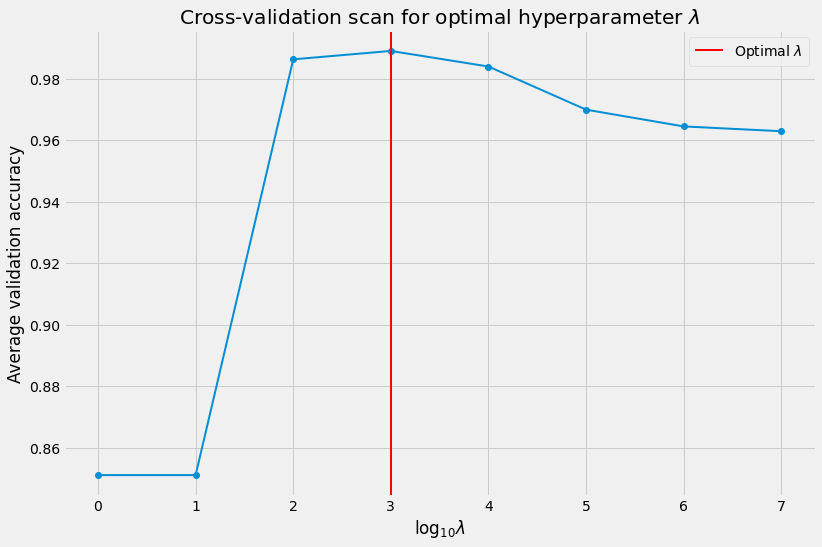

In [88]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(0, 8), mean_scores_svm.values(), '-o', linewidth=2)
plt.xlabel(r'$\log_{10} \lambda$')
plt.ylabel('Average validation accuracy')
plt.title('Cross-validation scan for optimal hyperparameter 'r'$\lambda$')
plt.axvline(3, color='red', linewidth=2, label='Optimal 'r'$\lambda$')
plt.legend()

We can see that in the limit $\lambda \to 0$, the cost function $L(w; \lambda)$ is dominated by the first term $\frac{1}{2}\|w\|^2$ and hence the optimization is just trying to fit a hyperplane between the two closest points belonging to two different classes (this leads to sever under-fitting). As we increase $\lambda$, we can see that the model starts performing better, hitting a peak before performance starts dropping off again. In the limit $\lambda \to \infty$, the cost function $L(w; \lambda)$ is dominated by the hinge term and hence the optimization is trying to separate the data as best as possible (contrarily, this leads to severe over-fitting).

In [89]:
r = max(mean_scores_svm, key=mean_scores_svm.get)

print('Optimal hardness: {}'.format(r))

w = train_svm_sgd(X_train, y_train, regul_strength=r)

Optimal hardness: 1000


In [90]:
y_pred = predict_svm(w, X_train)
acc_train = accuracy(y_train, y_pred)
print('Accuracy for train data: {}'.format(acc_train))

Accuracy for train data: 0.990646921278254


Reimporting the test data and changing outcome labels to $-1$ and $1$:

In [91]:
tumours_test = pd.read_csv('tumour_test.csv')
tumours_test = tumours_test.drop(['Unnamed: 0'], axis=1)
tumours_test = tumours_test.replace({'B': -1.0, 'M': 1.0})

In [92]:
X_test = tumours_test.loc[:, tumours_test.columns != target].to_numpy()
X_test = augument(standardise(X, X_test))
y_test = tumours_test[target].to_numpy()

In [93]:
y_test_pred = predict_svm(w, X_test)
acc_test = accuracy(y_test, y_test_pred)
print('Accuracy for test data: {}'.format(acc_test))

Accuracy for test data: 0.99


We can see that the SVM model also performs well (arround $99\%$ accuracy both in and out of sample). One key aspect that we can deduce from these results is that most likely, the clustering of the positives in the data set (that we deduced from the k-NN model) is _not_ linear. If it was linear (i.e. the negatives and the positives can be separated by a hyperplane), we would have expected the SVM to also have an accuracy of $100\%$. This suggests that a kernelised SVM (with a carefully chosen kernel function) may improve modelling results even more.

### ROC curves {-}

We will now vary the hardness parameters to see how it affects the performance of out SVM classifier. We will represent the results using the associated ROC curves of each model (i.e. we will set the hardness hyperparameter $\lambda$ to a fixed value and construct a ROC curve by varying the classification threshold across all the predicted values).

In [94]:
def roc_curve(X_train, y_train, X_test, y_test, r, ax):
    TPR_list = []
    FPR_list = []

    w = train_svm_sgd(X_train, y_train, regul_strength=r)
    thresholds = np.unique(X_train @ w)
    for val in thresholds:
        y_pred = predict_svm(w, X_test, threshold=val)
        TPR = true_positive_rate(y_test, y_pred)
        FPR = false_positive_rate(y_test, y_pred)
        TPR_list.append(TPR)
        FPR_list.append(FPR)

    ax.plot(FPR_list, TPR_list, linewidth=2, label=r'$\lambda$'' = '+str(r))
    ax.legend()

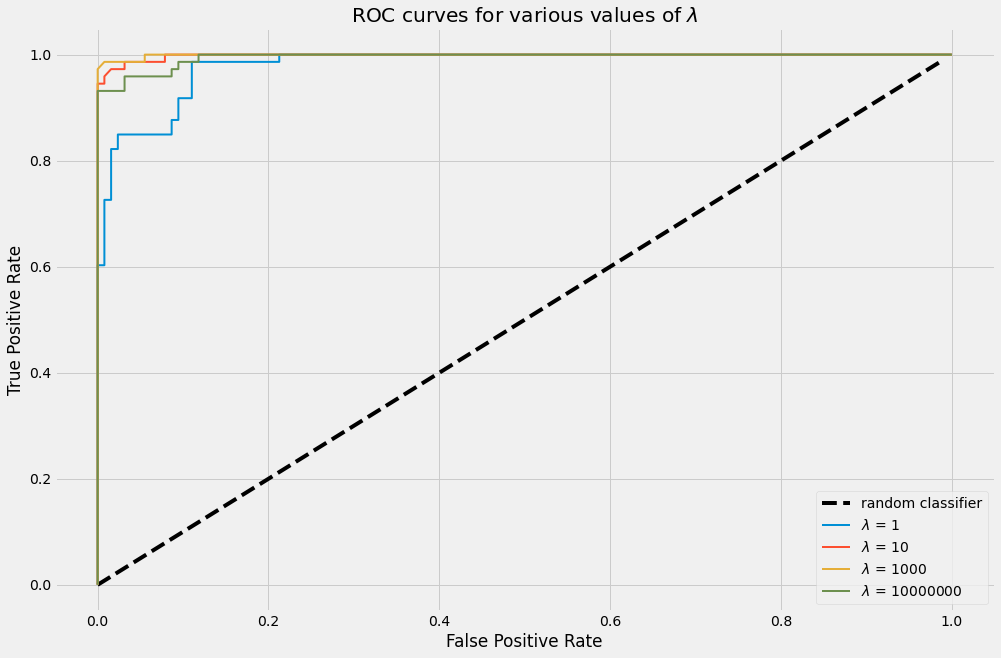

In [95]:
fix, ax = plt.subplots(figsize=(15, 10))
ax.plot(np.arange(0, 1, .01), np.arange(0, 1, .01), '--', color='black', label='random classifier')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curves for various values of 'r'$\lambda$')
ax.legend()

for r in [1, 10, 1000, 10000000]:
    roc_curve(X_train, y_train, X_test, y_test, r=r, ax=ax)

We can see that the results are in line with what we obtained from the cross-validation procedure: $\lambda = 1000$ appears to be the optimal value for the hardness hyperparameter. We can observe that as we increase $\lambda$ (from $1$ to the optimal value), the ROC curve gets better (higher area under the curve), but in the limit $\lambda \to \infty$ the model starts producing worse results.

### Training on balanced data set {-}

Lastly, we will retrain an SVM model on a balanced data set to see how this change affects modelling results.

In [96]:
tumours_bal = pd.read_csv('tumour_samples_bal.csv')
tumours_bal = tumours_bal.drop(['Unnamed: 0'], axis=1)
tumours_bal = tumours_bal.replace({'B': -1.0, 'M': 1.0})

In [97]:
X_bal = tumours_bal.loc[:, tumours_bal.columns != target].to_numpy()
X_bal = augument(standardise(X_bal))
y_bal = tumours_bal[target].to_numpy()

data = np.hstack([X_bal, y_bal.reshape(-1, 1)])

Finding optimal hyperparameter $\lambda$ for the SVM model:

In [98]:
r_list = [10 ** i for i in range(0, 8)]

mean_scores_svm_bal = {}

for r in r_list:
    scores = cross_validation_evaluate_svm(data, regul_strength=r)[1]
    mean_scores_svm_bal[r] = np.mean(scores)

In [99]:
mean_scores_svm_bal

{1: 0.9174999999999999,
 10: 0.9574999999999999,
 100: 0.9724999999999999,
 1000: 0.9724999999999999,
 10000: 0.9674999999999999,
 100000: 0.9512499999999999,
 1000000: 0.95875,
 10000000: 0.95625}

At a first glance, it may look as though the newly trained models on the balanced data set are performing worse than the ones obtained before. In reality, however, since the data is now balanced, the accuracy of the prediction will not be diluted by the high number of correctly classified negatives anymore and consequently, we will record lower values.

In [100]:
r = max(mean_scores_svm_bal, key=mean_scores_svm_bal.get)

print('Optimal hardness: {}'.format(r))

w_bal = train_svm_sgd(X_bal, y_bal, regul_strength=r*10)

Optimal hardness: 100


_Note:_ We can see that we get the same out of sample mean accuracy for both $\lambda=100$ and $\lambda=1000$; we will choose the latter since it is likely it will produce better results.

In [101]:
y_bal_pred = predict_svm(w_bal, X_bal)
acc_bal = accuracy(y_bal, y_bal_pred)
print('Accuracy for balanced data: {}'.format(acc_test))

Accuracy for balanced data: 0.99


We can see that the accuracy for the balanced data set is roughly the same that was observed for the unbalanced data set (around $99\%$), but this figure is way more remarkable in this case than it was previously. In the case of a balanced data set (points are roughly equally split between the two labels), if we classify each point at random with equal probability, the expected accuracy for the random model is $50\%$ (so an accuracy of $99\%$ is a notable improvement). On the other hand, in the case of an imbalanced data set (say the proportion of negatives in the set is $p\%$, with $p$ close to $1$; in our case $p \approx 80\%$), we can consider a random model that simply assigns a negative label to all the points in the data set, leading to an accuracy of $p\%$! This may look remarkable, but, in reality, a higher accuracy is easier to achieve for an imbalanced data set. Thus, using these observations, we can once again reinforce the idea that the error metric that we use to evaluate the performance of a model needs to be carefully chosen to obtain meaningful results for the task at hand.

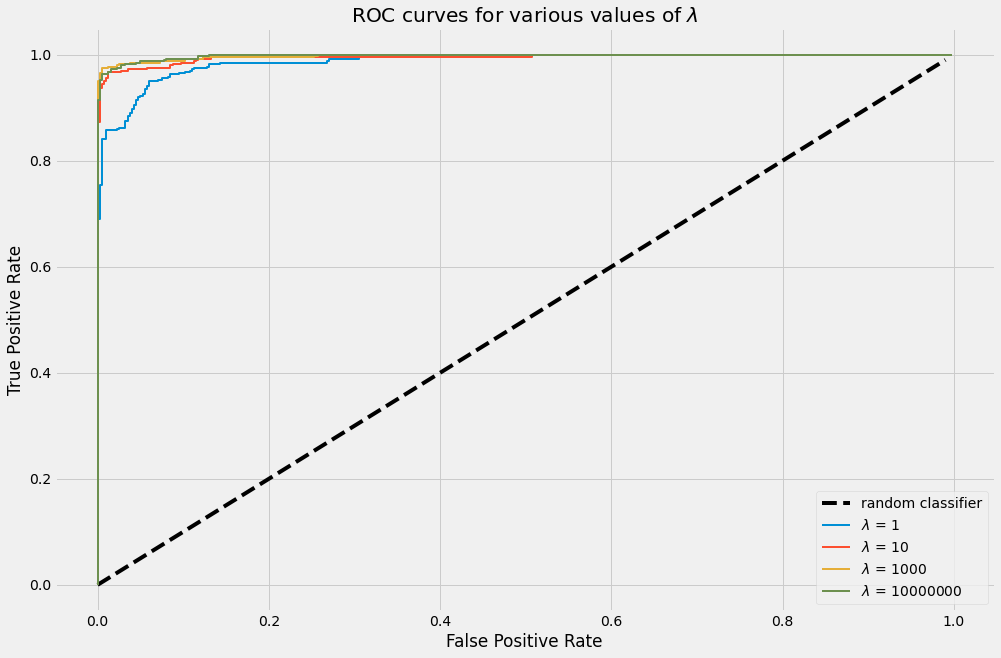

In [102]:
fix, ax = plt.subplots(figsize=(15, 10))
ax.plot(np.arange(0, 1, .01), np.arange(0, 1, .01), '--', color='black', label='random classifier')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curves for various values of 'r'$\lambda$')
ax.legend()

for r in [1, 10, 1000, 10000000]:
    roc_curve(X_bal, y_bal, X_bal, y_bal, r=r, ax=ax)

Again, we can see that the results of the cross-validation procedure are in line with the results represented above by the ROC curves: $\lambda=1000$ seems to produce the highest AUC. Important to note, however, is that contrary to what we observed earlier, the performance of the model does not seem to decrease as $\lambda \to \infty$ (most likely this suggests that the data is easier to separate now that the set is balanced, so the model does not over-fit as much).